# Car price evaluation


## 01 Problem description

Let's imagine a situation when I decided to sell my used car, how do I know how much it worth? In order to figure this out I can use data from autoscout24 to build the model that predicts price of used car in Germany. Lucklily there is already a dataset on kaggle - https://www.kaggle.com/ander289386/cars-germany

## 02 Data Preparation

In [59]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [60]:
df = pd.read_csv('autoscout24-germany-dataset.csv')
print('Number of Rows: %d' % len(df))

Number of Rows: 46405


Let's make column names and values uniform

In [61]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
df.head()    

,mileage,make,model,fuel,gear,offertype,price,hp,year
0,235000,bmw,316,diesel,manual,used,6800,116.0,2011
1,92800,volkswagen,golf,gasoline,manual,used,6877,122.0,2011
2,149300,seat,exeo,gasoline,manual,used,6900,160.0,2011
3,96200,renault,megane,gasoline,manual,used,6950,110.0,2011
4,156000,peugeot,308,gasoline,manual,used,6950,156.0,2011


let's look that column types are ok

In [62]:
df.dtypes

mileage        int64
make          object
model         object
fuel          object
gear          object
offertype     object
price          int64
hp           float64
year           int64
dtype: object

## 03 EDA and Feature Engineering

### 03.1 High level analysis

# how many empty values do we have?

In [63]:
df.isnull().sum()

mileage        0
make           0
model        143
fuel           0
gear         182
offertype      0
price          0
hp            29
year           0
dtype: int64

In [64]:
df.describe()

,mileage,price,hp,year
count,4.640500e+04,4.640500e+04,46376.000000,46405.000000
mean,7.117786e+04,1.657234e+04,132.990987,2016.012951
std,6.262531e+04,1.930470e+04,75.449284,3.155214
min,0.000000e+00,1.100000e+03,1.000000,2011.000000
25%,1.980000e+04,7.490000e+03,86.000000,2013.000000
50%,6.000000e+04,1.099900e+04,116.000000,2016.000000
75%,1.050000e+05,1.949000e+04,150.000000,2019.000000
max,1.111111e+06,1.199900e+06,850.000000,2021.000000


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offertype  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


After base preparation we got a dataset with:  
* 46405 rows  
* nine features (five categorical, four numerical)
* 182 missing values in gear column
* 143 missing values in model column
* 71177.86 mean mileage
* 16572.33 mean price
* 132.99 mean hp, 29 missing HP values

Let's fill empty HP with mean and drop rows with missing categorical values first
Also let's drop duplicates if any

In [66]:
df = df[(df.model.isnull() == False) & (df.gear.isnull() == False)]

hp_mean = df.hp.mean()
df['hp'] = df['hp'].fillna(hp_mean)

df = df.drop_duplicates(keep='first')
df.isnull().sum()

mileage      0
make         0
model        0
fuel         0
gear         0
offertype    0
price        0
hp           0
year         0
dtype: int64

### 03.2 Numerical features

Next let's have a look at numeric feature we have

#### 03.2.1 Feature importance

First we are going to build a correlation matrix to understand more abot feature importance

In [67]:
# Build a correllation matrix
numerical = list(df.dtypes[(df.dtypes.values == 'float64') | (df.dtypes.values == 'int')].index)

corr_df = df[numerical]
corrMatrix = corr_df.corr()
corrMatrix

,mileage,price,hp,year
mileage,1.000000,-0.305652,-0.022898,-0.670604
price,-0.305652,1.000000,0.744934,0.411535
hp,-0.022898,0.744934,1.000000,0.181882
year,-0.670604,0.411535,0.181882,1.000000


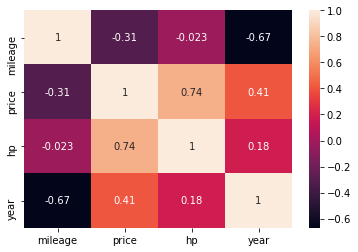

In [68]:
sns.heatmap(corrMatrix, annot=True)
plt.show()

HP affects price the most, then year. Mileage is the least important feature

#### 03.2.2 Price

First we need to look at target (price)

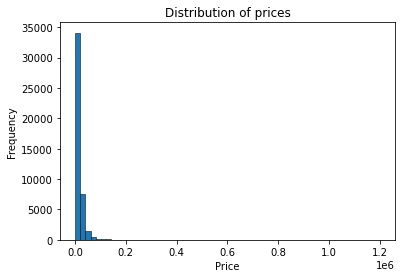

In [69]:
plt.figure(figsize=(6, 4))

sns.histplot(df.price, bins=60, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

Data has long tail due to some outliers

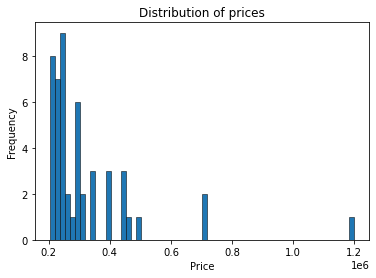

In [70]:
plt.figure(figsize=(6, 4))

sns.histplot(df.price[df.price > 200000], bins=60, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

Let's remove records with prices higher than 450000. Also we are going to apply log transformation to it

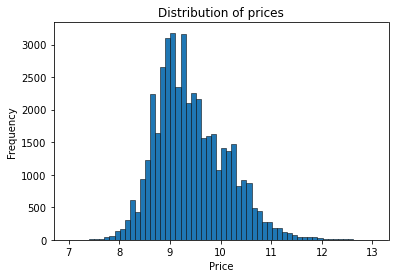

In [71]:
df = df[df.price <= 450000]
df.price = np.log1p(df.price)
plt.figure(figsize=(6, 4))

sns.histplot(df.price, bins=60, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

#### 03.2.3 Mileage

Let's have a closer look at mileage

In [72]:
df.mileage.describe().apply("{0:.2f}".format)

count      43961.00
mean       72316.89
std        62197.18
min            0.00
25%        21500.00
50%        61302.00
75%       106000.00
max      1111111.00
Name: mileage, dtype: object

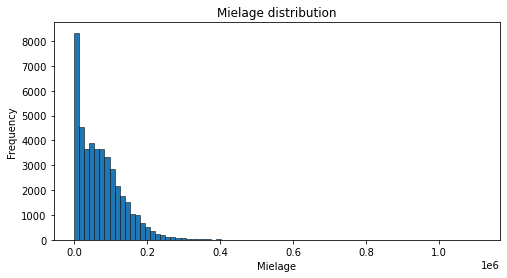

In [73]:
plt.figure(figsize=(8, 4))

sns.histplot(df.mileage, bins=80, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Mielage')
plt.title('Mielage distribution')

plt.show()

Mileage have a long tail, let's look at this closer

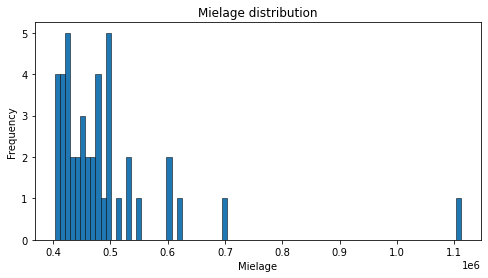

In [74]:
plt.figure(figsize=(8, 4))

sns.histplot(df.mileage[df.mileage > 400000], bins=80, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Mielage')
plt.title('Mielage distribution')

plt.show()

Let's remove data where mileage is higher than 400k kilometers

In [75]:
df = df[df.mileage <= 400000]
df.count()

mileage      43918
make         43918
model        43918
fuel         43918
gear         43918
offertype    43918
price        43918
hp           43918
year         43918
dtype: int64

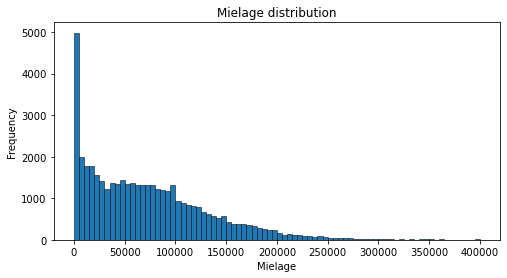

In [76]:
plt.figure(figsize=(8, 4))

sns.histplot(df.mileage, bins=80, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Mielage')
plt.title('Mielage distribution')

plt.show()

Let's plot how mileage looks against price

<AxesSubplot:xlabel='mileage', ylabel='price'>

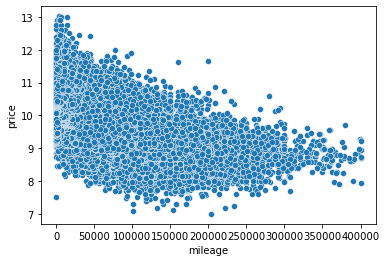

In [77]:
sns.scatterplot(x=df['mileage'], y=df['price'])

#### 03.2.4 HP

We have some missing values in this column

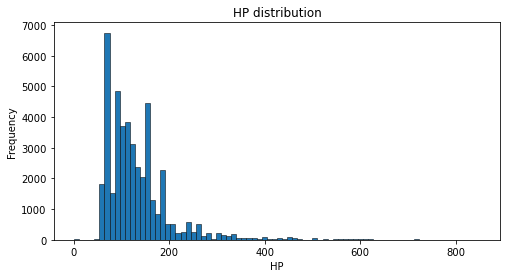

In [78]:
plt.figure(figsize=(8, 4))

sns.histplot(df.hp, bins=80, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('HP')
plt.title('HP distribution')

plt.show()

Let's remove HP greater than 400 and less than 30

In [79]:
df = df[(df.hp <= 400) & (df.hp > 30)]
df.count()

mileage      43215
make         43215
model        43215
fuel         43215
gear         43215
offertype    43215
price        43215
hp           43215
year         43215
dtype: int64

<AxesSubplot:xlabel='hp', ylabel='price'>

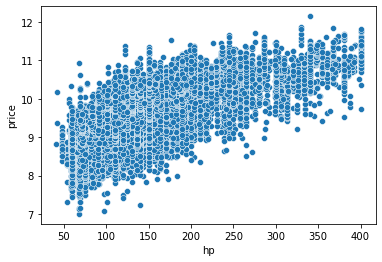

In [80]:
sns.scatterplot(x=df['hp'], y=df['price'])

HP looks mostly ok

### 03.2.5 Year  

Let's look at year distribution

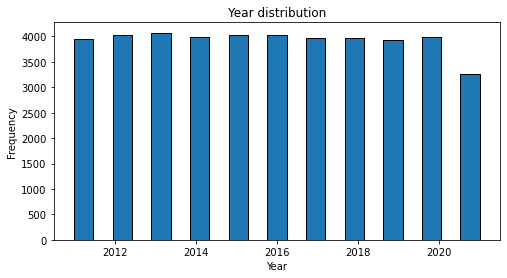

In [81]:
plt.figure(figsize=(8, 4))

sns.histplot(df.year, bins=21, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Year')
plt.title('Year distribution')

plt.show()

<AxesSubplot:xlabel='year', ylabel='price'>

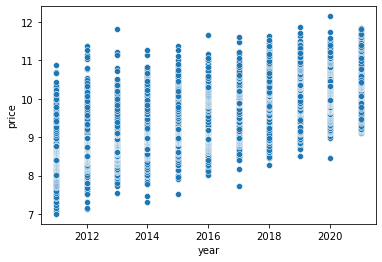

In [82]:
sns.scatterplot(x=df['year'], y=df['price'])

Years looks more or less evently distributed. We cam iprove our dataset by adding age feature. This will ensure that model works better for future data

<AxesSubplot:xlabel='age', ylabel='price'>

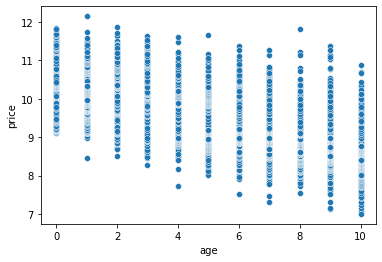

In [83]:
from datetime import datetime

df['age'] = datetime.now().year - df['year']
sns.scatterplot(x=df['age'], y=df['price'])

### 03.3 Categorical features

Next we need to look at categorical features we have

#### 03.3.1 Feature importance

We can calculate mutual information for categorical features in order to estimate importance. In order to do that we need to transform numerical feature price into categorical. We will use pandas qunatile cut to achieve this.

In [84]:
categorical = list(df.dtypes[(df.dtypes.values == 'object')].index)

qprice = pd.qcut(df.price, q=10)

from sklearn.metrics import mutual_info_score

for cat in categorical:
    print(cat, ': ', mutual_info_score(df[cat], qprice).round(2))

make :  0.16
model :  0.54
fuel :  0.04
gear :  0.19
offertype :  0.09


Model and Make are the most important, a offertype almost does not affect price. Let's remove it.

In [85]:
del df['offertype']

In [86]:
categorical = list(df.dtypes[(df.dtypes.values == 'object')].index)
categorical

['make', 'model', 'fuel', 'gear']

Now we can have a look at most important categorical features

#### 03.3.2 Make

Least popular makes

In [87]:
df.make.value_counts().tail(30)

jeep          143
alfa          124
jaguar        110
porsche       107
cupra          63
subaru         57
abarth         41
ssangyong      36
lexus          36
lada           31
lancia         16
ds             16
dodge          11
infiniti       11
daihatsu       10
maserati        6
cadillac        5
chrysler        5
alpina          3
tesla           3
baic            2
dfsk            2
morgan          2
iveco           2
bentley         1
others          1
alpine          1
isuzu           1
brilliance      1
piaggio         1
Name: make, dtype: int64

Most popular makes

In [88]:
df.make.value_counts().head(15)

volkswagen       6663
opel             4577
ford             4228
skoda            2736
renault          2646
audi             2416
bmw              2276
mercedes-benz    2106
seat             1828
hyundai          1737
fiat             1489
peugeot          1174
toyota           1142
kia               948
citroen           918
Name: make, dtype: int64

#### 03.3.3 Fuel

In [89]:
df.fuel.value_counts()

gasoline             26722
diesel               14576
electric/gasoline      991
electric               591
cng                    113
lpg                    105
electric/diesel         49
others                  45
-/-_(fuel)              20
ethanol                  2
hydrogen                 1
Name: fuel, dtype: int64

We can observe value of '-/-_(fuel)'. We can assume that this is the same as 'others', let's fix it

In [90]:
df.fuel = df.fuel.replace('-/-_(fuel)', 'others')
df.fuel.value_counts()

gasoline             26722
diesel               14576
electric/gasoline      991
electric               591
cng                    113
lpg                    105
others                  65
electric/diesel         49
ethanol                  2
hydrogen                 1
Name: fuel, dtype: int64

## 04 Training Models

### 04.1 Splitting the data

We will use train_test_split to split the data and DictVectorizer to do one hot encoding on categorical features

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train.price.values
y_val   = df_val.price.values
y_test  = df_test.price.values
y_full_train = df_full_train.price.values

del df_train['price']
del df_val['price']
del df_test['price']

y_train, df_train.head(2).to_dict(orient='records')

(array([ 9.14857135,  8.10198073,  9.13248693, ...,  9.6091836 ,
        10.03806215,  9.27809247]),
 [{'mileage': 69500,
   'make': 'renault',
   'model': 'scenic',
   'fuel': 'diesel',
   'gear': 'manual',
   'hp': 110.0,
   'year': 2015,
   'age': 6},
  {'mileage': 119595,
   'make': 'renault',
   'model': 'twingo',
   'fuel': 'gasoline',
   'gear': 'manual',
   'hp': 75.0,
   'year': 2012,
   'age': 9}])

Now we use DicVectorizer to do one hot encoding for train and validation

In [92]:
numerical = ['mileage', 'hp', 'year', 'age']
categorical = ['make', 'model', 'fuel', 'gear']

dv = DictVectorizer(sparse=False) 

train_dicts = df_train[numerical + categorical].to_dict(orient='records') 
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_train.shape

(25929, 756)

### 04.2 Training Ridge

In [93]:
from sklearn.linear_model import Ridge

Let's train basic Ridge

In [94]:
def TrainModel_Ridge(alpha_=1,normalize_=False):
    model_ = Ridge(alpha=alpha_, random_state=42, normalize=normalize_)
    model_.fit(X_train, y_train)

    y_pred_ = model_.predict(X_val)

    return y_pred_

Let's look at RMSE of default model

In [95]:
def rmse(yp, y_predp):
    se = (yp - y_predp) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [96]:
    y_pred = TrainModel_Ridge(1, False)
    rmse(y_val, y_pred)
    
   # y_val, y_pred

0.14829667746719716

<AxesSubplot:ylabel='Count'>

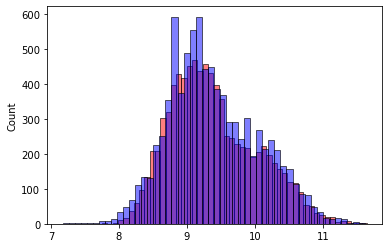

In [97]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)


Let's try to tune model to get better results

In [98]:
from tqdm.auto import tqdm

In [100]:
alphas = [0.05, 0.1, 1, 5, 10]
norm = [False, True]

for n in tqdm(norm):
    for a in alphas:
        y_pred = TrainModel_Ridge(a)
        print('norm: %s, alpha: %s, rmse: %.3f' % (n, a, rmse(y_val, y_pred)))

  0%|          | 0/2 [00:00<?, ?it/s]

norm: False, alpha: 0.05, rmse: 0.148
norm: False, alpha: 0.1, rmse: 0.148
norm: False, alpha: 1, rmse: 0.148
norm: False, alpha: 5, rmse: 0.151
norm: False, alpha: 10, rmse: 0.155
norm: True, alpha: 0.05, rmse: 0.148
norm: True, alpha: 0.1, rmse: 0.148
norm: True, alpha: 1, rmse: 0.148
norm: True, alpha: 5, rmse: 0.151
norm: True, alpha: 10, rmse: 0.155


Looks like default model parameters give the best results
Let's train the final ridge model

In [44]:
model_ridge = Ridge(alpha=1, random_state=42, normalize=False)
model_ridge.fit(X_train, y_train)

y_pred_ridge_train = model_ridge.predict(X_train)
y_pred_ridge = model_ridge.predict(X_val)

rmse_results = []
rmse_results.append(('Ridge', rmse(y_val, y_pred_ridge), rmse(y_train, y_pred_ridge_train)))
rmse_results

[('Ridge', 0.14829667746719716, 0.1435849993940705)]

### 04.3 Training Regression Tree

Now let's train basic regression tree model

In [45]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [46]:
rmse(y_val, y_pred)

0.21191958747993225

<AxesSubplot:ylabel='Count'>

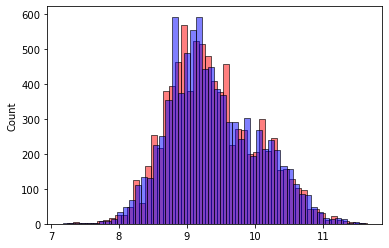

In [47]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_val, color='blue', alpha=0.5, bins=50)

Let's try to tune different parameters

In [48]:
def train_tree(max_depth_, min_samples_leaf_, max_leaf_nodes_=None,criterion_='mse'):
#     train_dicts_ = df_train[features_].to_dict(orient='records')
#     dv_ = DictVectorizer(sparse=False) 
#     X_train_ = dv_.fit_transform(train_dicts_)

#     val_dicts_ = df_val[features_].to_dict(orient='records') #doing the same for validation DS
#     X_val_ = dv_.transform(val_dicts)

    model_ = DecisionTreeRegressor(random_state=42, max_depth=max_depth_, min_samples_leaf=min_samples_leaf_, max_leaf_nodes=max_leaf_nodes_,criterion=criterion_)
    model_.fit(X_train, y_train)

    y_pred_ = model_.predict(X_val)
    
    return y_pred_

In [49]:
depths = [1,2,3,4,5,6,10,15,20,50,100,None]

scores = []

for d in tqdm(depths):
    y_pred = train_tree(d, 1)
    rmse_val = rmse(y_val, y_pred)
    print('depth %s: rmse: %.3f' % (d, rmse_val))
    scores.append((d, rmse_val))

  0%|          | 0/12 [00:00<?, ?it/s]

depth 1: rmse: 0.503
depth 2: rmse: 0.381
depth 3: rmse: 0.325
depth 4: rmse: 0.286
depth 5: rmse: 0.263
depth 6: rmse: 0.242
depth 10: rmse: 0.209
depth 15: rmse: 0.199
depth 20: rmse: 0.203
depth 50: rmse: 0.211
depth 100: rmse: 0.212
depth None: rmse: 0.212


Best depth is 15. Now let's look at min_samples_leaf

In [50]:
df_scores = pd.DataFrame(scores, columns=['depth','rmse'])
df_scores.sort_values('rmse')

,depth,rmse
7,15.0,0.199174
8,20.0,0.203424
6,10.0,0.208525
9,50.0,0.210832
10,100.0,0.211920
11,NaN,0.211920
5,6.0,0.242432
4,5.0,0.262899
3,4.0,0.285853
2,3.0,0.324523


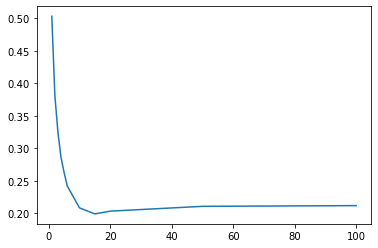

In [51]:
plt.plot(df_scores.depth, df_scores.rmse)

In [52]:
depths = [12,14,15,16,18]
min_samples = [1,2,4,5,6,10,12,15,17,20,100]

scores = []

for d in tqdm(depths):
    print('depth=%s' % d)
    for s in min_samples:
        y_pred = train_tree(d, s)
        scores.append((d,s,rmse(y_val, y_pred).round(3)))
    #print('depth %s: rmse: %.3f' % (d, rmse(y_val, y_pred))) 
    
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'rmse'])
df_scores.sort_values('rmse').head(5)

  0%|          | 0/5 [00:00<?, ?it/s]

depth=12
depth=14
depth=15
depth=16
depth=18


,max_depth,min_samples_leaf,rmse
24,15,4,0.197
26,15,6,0.198
25,15,5,0.198
11,14,1,0.198
13,14,4,0.198


Best min_samples_leaf is 4. Let's peek the best max leaf nodes

In [53]:
min_samples = [3,4,5]
max_leaf_nodes = [None,100,1000,1500,2000,2500,3000]
scores = []

for s in tqdm(min_samples):
    print('min_samples=%s' % s)
    for l in max_leaf_nodes:
        y_pred = train_tree(15, s, l)
        scores.append((s,l,rmse(y_val, y_pred).round(3)))

df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'max_leaf_nodes', 'rmse'])
df_scores.sort_values('rmse').head(5)

  0%|          | 0/3 [00:00<?, ?it/s]

min_samples=3
min_samples=4
min_samples=5


,min_samples_leaf,max_leaf_nodes,rmse
10,4,1500.0,0.196
3,3,1500.0,0.196
4,3,2000.0,0.196
5,3,2500.0,0.196
11,4,2000.0,0.196


<AxesSubplot:xlabel='None-max_leaf_nodes', ylabel='min_samples_leaf'>

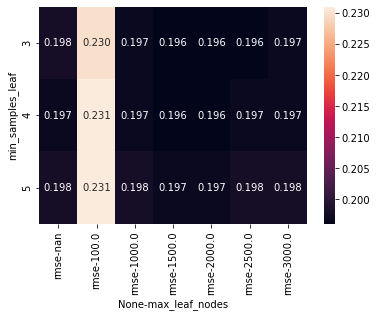

In [54]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_leaf_nodes'], values=['rmse'])
df_scores_pivot.round(3)

sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

So, the best aparameters are max_depth=15 min_samples_leaf=4 max_leaf_nodes=1500
Now we will train final model

In [55]:
model_reg_tree = DecisionTreeRegressor(random_state=42,max_depth=15,min_samples_leaf=4,max_leaf_nodes=1500)
model_reg_tree.fit(X_train, y_train)

y_pred_reg_tree = model_reg_tree.predict(X_val)
y_pred_reg_tree_train = model_reg_tree.predict(X_train)

rmse_results.append(('Reg_tree', rmse(y_val, y_pred_reg_tree), rmse(y_train, y_pred_reg_tree_train)))
rmse_results

[('Ridge', 0.14829667746719716, 0.1435849993940705),
 ('Reg_tree', 0.1959388459647658, 0.15313221592567927)]

### 04.4 Training Random Forest

Next we will train default random forest regression model

In [56]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
y_pred_train  = rf.predict(X_train)

rmse(y_val, y_pred), rmse(y_train, y_pred_train)

(0.1612333490504326, 0.06208425325496527)

As usual model shows signs of overfitting and rmse on validation dataset is not the best. Let's try to tweak it

In [58]:
def train_random_forest(n_estimators_=100, max_depth_=None, min_samples_leaf_=1):

    model_ = RandomForestRegressor(n_estimators=n_estimators_, max_depth=max_depth_, min_samples_leaf=min_samples_leaf_, random_state=42, n_jobs=4)
    model_.fit(X_train, y_train)

    y_pred_ = model_.predict(X_val)
    
    return y_pred_

We are going to start with tweaking number of estimators

In [59]:
scores = []
ns = range(30, 251, 10);
for n in tqdm(ns):
    y_pred = train_random_forest(n_estimators_=n)
    scores.append((n, rmse(y_val, y_pred)))

  0%|          | 0/23 [00:00<?, ?it/s]

In [60]:
df_scores = pd.DataFrame(scores, columns=['n_estimators','rmse'])
df_scores.sort_values('rmse')

,n_estimators,rmse
22,250,0.160971
14,170,0.160993
12,150,0.161001
15,180,0.161004
21,240,0.161016
13,160,0.161035
16,190,0.161057
20,230,0.161089
11,140,0.161106
19,220,0.161112


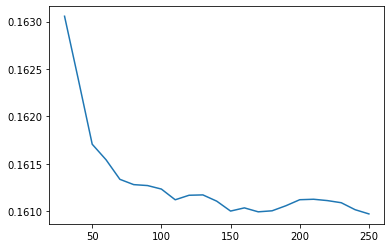

In [61]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

The rmse stabilizes around 150 estimators, we will play around this value. Next we need to choose the best max_depth

In [62]:
scores = []

depths = range(20, 51, 10)
estimators = [100, 125, 150, 175, 200]

for d in tqdm(depths):
    for n in estimators:
        y_pred = train_random_forest(n_estimators_=n, max_depth_=d)       
        scores.append((d, n, rmse(y_val, y_pred)))

  0%|          | 0/4 [00:00<?, ?it/s]

In [63]:
columns = ['max_depth','n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values('rmse').head()

,max_depth,n_estimators,rmse
8,30,175,0.160866
7,30,150,0.160904
13,40,175,0.160977
9,30,200,0.160988
12,40,150,0.160989


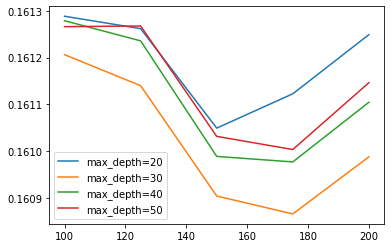

In [64]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
    
plt.legend()  

Looks like max_depth 30 and number of estimators 175 are the best settings. The difference is small thiugh. Nevertheless we will use these settings to choose the best min_samples_leaf parameter

In [65]:
scores = []

n_estimators = 175
max_depth = 30

min_samples_leaf = [1,3,5,10,50]

for s in tqdm(min_samples_leaf):    
        y_pred = train_random_forest(n_estimators_=n_estimators, 
                                    max_depth_=max_depth, 
                                    min_samples_leaf_=s)       
        scores.append((s, rmse(y_val, y_pred)))

  0%|          | 0/5 [00:00<?, ?it/s]

In [66]:
columns = ['min_samples_leaf','rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values('rmse').head()

,min_samples_leaf,rmse
0,1,0.160866
1,3,0.168511
2,5,0.173950
3,10,0.182298
4,50,0.206347


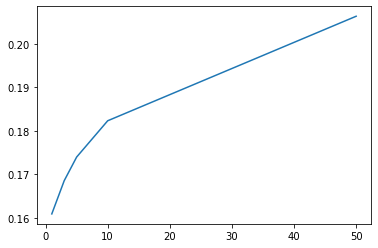

In [67]:
plt.plot(df_scores.min_samples_leaf, df_scores.rmse)

In [68]:
model_rand_forest = RandomForestRegressor(n_estimators=175, max_depth=30, min_samples_leaf=1, random_state=42, n_jobs=4)
model_rand_forest.fit(X_train, y_train)

y_pred_rand_forest = model_rand_forest.predict(X_val)
y_pred_rand_forest_train = model_rand_forest.predict(X_train)

rmse_results.append(('Rand_forest', rmse(y_val, y_pred_rand_forest), rmse(y_train, y_pred_rand_forest_train)))
rmse_results

[('Ridge', 0.14829667746719716, 0.1435849993940705),
 ('Reg_tree', 0.1959388459647658, 0.15313221592567927),
 ('Rand_forest', 0.16086571793591492, 0.06344112546096634)]

The difference between rmse on validation and train is a bit high here

### 04.5 Training XGBoost

The last model will train is gradient boosting

In [69]:
import xgboost as xgb

In [70]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [71]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        columns = ['num_iter','train_sqerr','val_sqerr']
        df_results  = pd.DataFrame(results,columns=columns)
       
    return df_results

In [72]:
watchlist = [(dtrain,'train'),(dval,'val')]

We will train it with basic parameters

In [73]:
scores = {}

In [74]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective':'reg:squarederror',
    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=50)

In [75]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [76]:
scores['eta=0.3']

,num_iter,train_sqerr,val_sqerr
0,0,6.24801,6.24235
1,5,1.07286,1.07180
2,10,0.25381,0.25735
3,15,0.17368,0.18043
4,20,0.16664,0.17455
5,25,0.16298,0.17169
6,30,0.15993,0.16948
7,35,0.15768,0.16779
8,40,0.15541,0.16650
9,45,0.15314,0.16480


In [77]:
df_score = scores['eta=0.3']

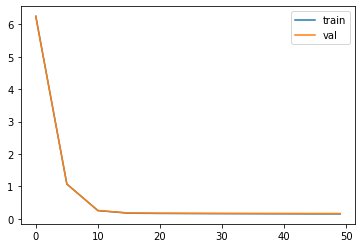

In [78]:
plt.plot(df_score.num_iter, df_score.train_sqerr, label='train')
plt.plot(df_score.num_iter, df_score.val_sqerr, label='val')
plt.legend()

We are going to use num_boost_round = 15 and train with different eta params

In [79]:
scores = {}

In [80]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [81]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [82]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [83]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [84]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [85]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1'

In [86]:
%%capture output

xgb_params = {
    'eta': 2, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [87]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=2'

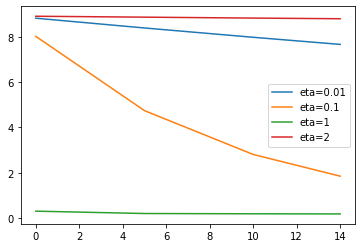

In [88]:
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_sqerr, label=key)
plt.legend()

Eta=1 looks the best. Now lets try different max_depth 

In [89]:
scores = {}

In [90]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [91]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [92]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [93]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [94]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [95]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [96]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 15,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [97]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=15'

In [98]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [99]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=20'

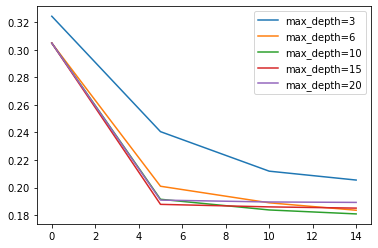

In [100]:
for key, df_scores in scores.items():
    #plt.plot(df_score.num_iter, df_score.train_auc, label='train')
    plt.plot(df_scores.num_iter, df_scores.val_sqerr, label=key)
plt.legend()

Max depth = 15 looks the best here. The last parameter we try to tune is min_child_weight

In [101]:
scores = {}

In [102]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 15,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [103]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [104]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 15,
    'min_child_weight': 5,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [105]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=5'

In [106]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 15,
    'min_child_weight': 10,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [107]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [108]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 15,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [109]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

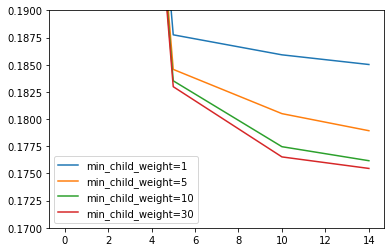

In [110]:
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_sqerr, label=key)
plt.ylim(0.17, 0.19)   
plt.legend()

Min weight 30 gives slightly better results. Let's train final model

In [111]:
%%capture output

xgb_params = {
    'eta': 1, 
    'max_depth': 15,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model_xgb = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=15)

In [112]:
y_pred_xgboost = model_xgb.predict(dval)
y_pred_xgboost_train = model_xgb.predict(dtrain)

rmse_results.append(('XGBoost', rmse(y_val, y_pred_xgboost), rmse(y_train, y_pred_xgboost_train)))
rmse_results

[('Ridge', 0.14829667746719716, 0.1435849993940705),
 ('Reg_tree', 0.1959388459647658, 0.15313221592567927),
 ('Rand_forest', 0.16086571793591492, 0.06344112546096634),
 ('XGBoost', 0.1754617150543563, 0.1460123376882078)]

### 04.6 Choosing The Best Model

In [113]:
rmse_results

[('Ridge', 0.14829667746719716, 0.1435849993940705),
 ('Reg_tree', 0.1959388459647658, 0.15313221592567927),
 ('Rand_forest', 0.16086571793591492, 0.06344112546096634),
 ('XGBoost', 0.1754617150543563, 0.1460123376882078)]

Based on the results it looks like Ridge model works best for this dataset. Next we are going to train on full train dataset and test against test dataset

### 04.7 Testing The Best Model

In [115]:
numerical = ['mileage', 'hp', 'year', 'age']
categorical = ['make', 'model', 'fuel', 'gear']

dv = DictVectorizer(sparse=False) 

train_dicts = df_full_train[numerical + categorical].to_dict(orient='records') 
X_full_train = dv.fit_transform(train_dicts)

test_dicts = df_test[numerical + categorical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

X_full_train.shape, X_test.shape, y_full_train.shape

((34572, 790), (8643, 790), (34572,))

In [116]:
model = Ridge(alpha=1, random_state=42, normalize=False)
model.fit(X_full_train, y_full_train)

y_pred_full_train = model.predict(X_full_train)
y_pred = model.predict(X_test)

In [117]:
rmse(y_full_train, y_pred_full_train), rmse(y_test, y_pred)

(0.14373939609989025, 0.14732279084013022)

The rmse is consistent, we can save this model in order to use it in our app

## 05 Saving the model

In [118]:
import pickle

In [119]:
output_file = 'model.bin'
output_file

'model.bin'

In [120]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)